In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import mlflow
import mlflow.sklearn
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
import os


In [2]:
mlflow.set_experiment("Bank_Loan_Default_Prediction")

2025/07/01 19:18:30 INFO mlflow.tracking.fluent: Experiment with name 'Bank_Loan_Default_Prediction' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///C:/Users/Minfy/Desktop/new_env1/mlruns/117633151901532444', creation_time=1751377710489, experiment_id='117633151901532444', last_update_time=1751377710489, lifecycle_stage='active', name='Bank_Loan_Default_Prediction', tags={}>

In [7]:
df = pd.read_csv("D:/test/bankfinal1.csv")

# Strip leading/trailing spaces from column names (important!)
df.columns = df.columns.str.strip()

# View shape and first 5 rows
print("Shape of dataset:", df.shape)
print("\nFirst 5 rows:")
print(df.head())

# Basic info
print("\nData types and null values:")
print(df.info())


Shape of dataset: (5000, 14)

First 5 rows:
   ID  Age  Experience  Income  ZIP Code  Family  CCAvg  Education  Mortgage  \
0   1   25           1      49     91107       4    1.6          1         0   
1   2   45          19      34     90089       3    1.5          1         0   
2   3   39          15      11     94720       1    1.0          1         0   
3   4   35           9     100     94112       1    2.7          2         0   
4   5   35           8      45     91330       4    1.0          2         0   

   Personal Loan  Securities Account  CD Account  Online  CreditCard  
0              0                   1           0       0           0  
1              0                   1           0       0           0  
2              0                   0           0       0           0  
3              0                   0           0       0           0  
4              0                   0           0       0           1  

Data types and null values:
<class 'pandas.core.

In [8]:
# Summary of numerical features
df.describe()

# Check for missing values
df.isnull().sum()


ID                    0
Age                   0
Experience            0
Income                0
ZIP Code              0
Family                0
CCAvg                 0
Education             0
Mortgage              0
Personal Loan         0
Securities Account    0
CD Account            0
Online                0
CreditCard            0
dtype: int64

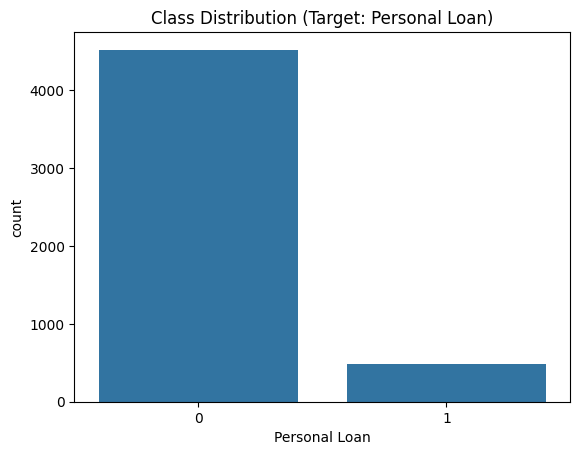

Personal Loan
0    0.904
1    0.096
Name: proportion, dtype: float64

In [9]:
# Target distribution
sns.countplot(x='Personal Loan', data=df)
plt.title("Class Distribution (Target: Personal Loan)")
plt.show()

# Value counts
df['Personal Loan'].value_counts(normalize=True)


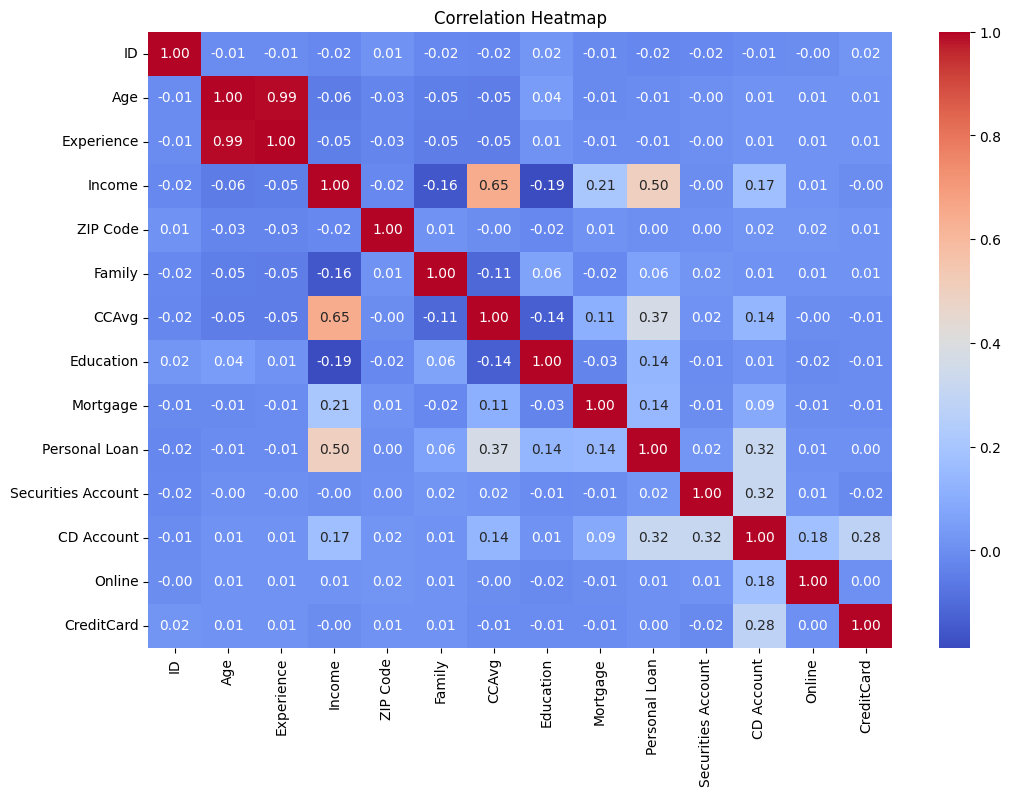

In [10]:
# Correlation with target
correlation = df.corr(numeric_only=True)
plt.figure(figsize=(12, 8))
sns.heatmap(correlation, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()


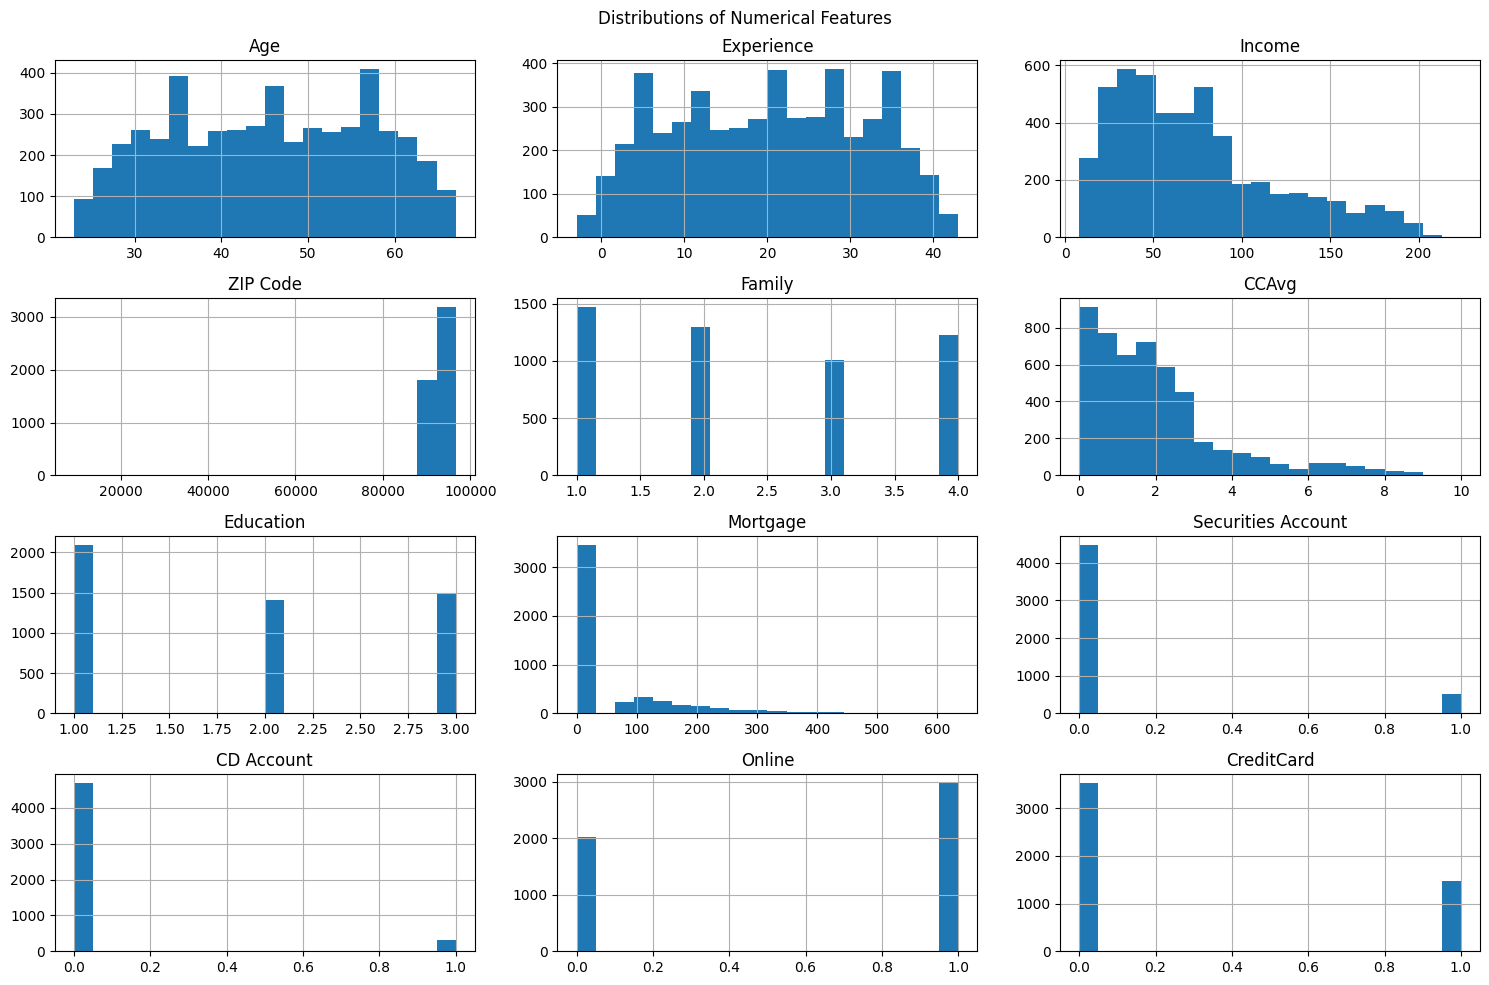

In [11]:
# Select numerical columns (excluding ID and target)
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.drop(['ID', 'Personal Loan'])

# Plot distributions
df[num_cols].hist(figsize=(15, 10), bins=20)
plt.suptitle("Distributions of Numerical Features")
plt.tight_layout()
plt.show()


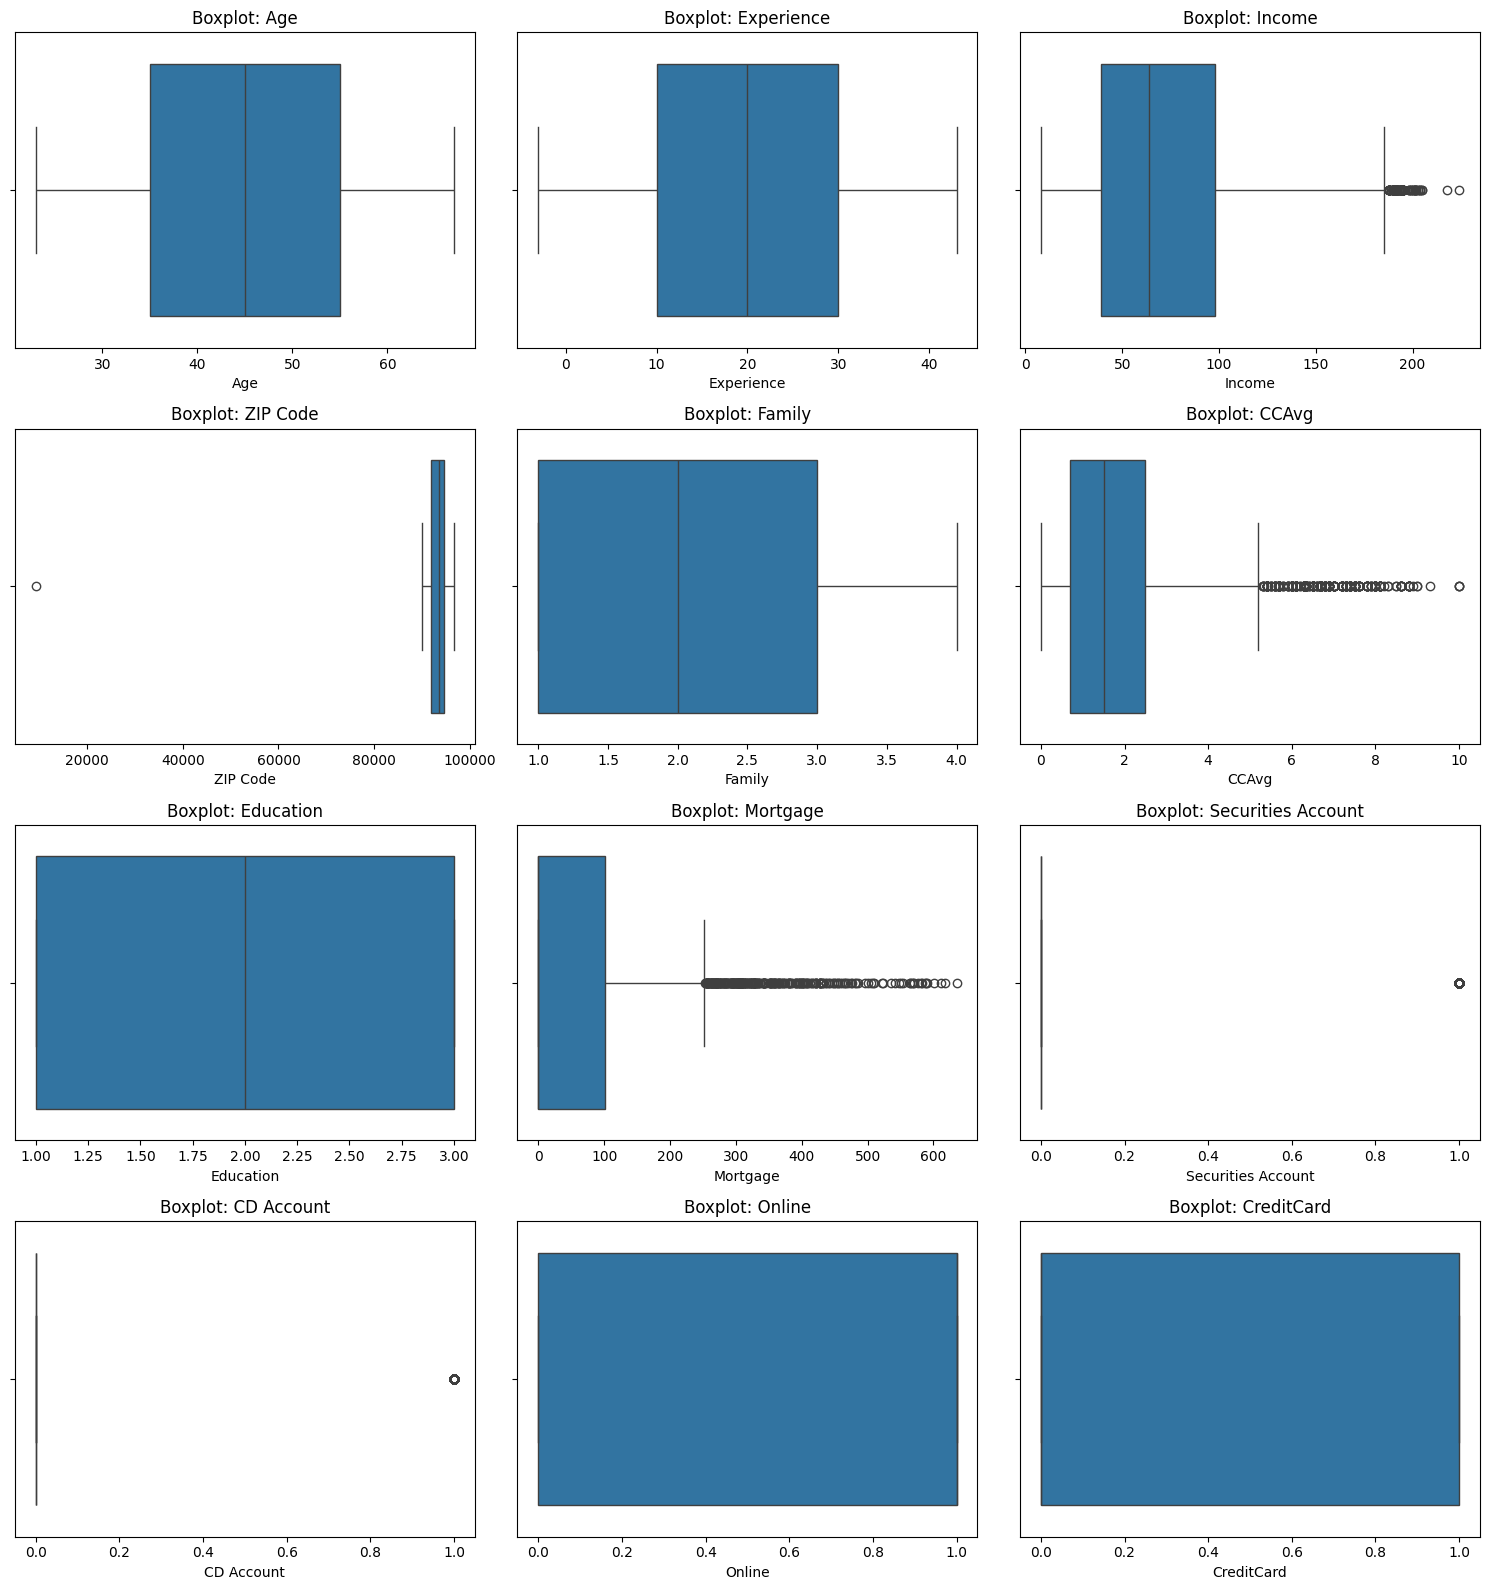

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
import math

# List of numeric columns
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.drop(['ID', 'Personal Loan'])

# Plot boxplots dynamically
n_cols = 3
n_rows = math.ceil(len(num_cols) / n_cols)

plt.figure(figsize=(n_cols * 5, n_rows * 4))

for i, col in enumerate(num_cols):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot: {col}')

plt.tight_layout()
plt.show()

In [13]:
# Check unique values of object (categorical) columns
cat_cols = df.select_dtypes(include=['object']).columns.tolist()

for col in cat_cols:
    print(f"\n{col} value counts:")
    print(df[col].value_counts())


In [14]:
# Get numerical columns (excluding ID if present)
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.drop('ID', errors='ignore')

# Compute range (min and max) for each
for col in num_cols:
    min_val = df[col].min()
    max_val = df[col].max()
    print(f"{col}: Min = {min_val}, Max = {max_val}, Range = {max_val - min_val}")


Age: Min = 23, Max = 67, Range = 44
Experience: Min = -3, Max = 43, Range = 46
Income: Min = 8, Max = 224, Range = 216
ZIP Code: Min = 9307, Max = 96651, Range = 87344
Family: Min = 1, Max = 4, Range = 3
CCAvg: Min = 0.0, Max = 10.0, Range = 10.0
Education: Min = 1, Max = 3, Range = 2
Mortgage: Min = 0, Max = 635, Range = 635
Personal Loan: Min = 0, Max = 1, Range = 1
Securities Account: Min = 0, Max = 1, Range = 1
CD Account: Min = 0, Max = 1, Range = 1
Online: Min = 0, Max = 1, Range = 1
CreditCard: Min = 0, Max = 1, Range = 1


In [15]:
# Show unique values in each column
for col in df.columns:
    unique_vals = df[col].unique()
    print(f"\n{col} ({df[col].dtype}):")
    print(f"Unique values ({len(unique_vals)}): {unique_vals}")



ID (int64):
Unique values (5000): [   1    2    3 ... 4998 4999 5000]

Age (int64):
Unique values (45): [25 45 39 35 37 53 50 34 65 29 48 59 67 60 38 42 46 55 56 57 44 36 43 40
 30 31 51 32 61 41 28 49 47 62 58 54 33 27 66 24 52 26 64 63 23]

Experience (int64):
Unique values (47): [ 1 19 15  9  8 13 27 24 10 39  5 23 32 41 30 14 18 21 28 31 11 16 20 35
  6 25  7 12 26 37 17  2 36 29  3 22 -1 34  0 38 40 33  4 -2 42 -3 43]

Income (int64):
Unique values (162): [ 49  34  11 100  45  29  72  22  81 180 105 114  40 112 130 193  21  25
  63  62  43 152  83 158  48 119  35  41  18  50 121  71 141  80  84  60
 132 104  52 194   8 131 190  44 139  93 188  39 125  32  20 115  69  85
 135  12 133  19  82 109  42  78  51 113 118  64 161  94  15  74  30  38
   9  92  61  73  70 149  98 128  31  58  54 124 163  24  79 134  23  13
 138 171 168  65  10 148 159 169 144 165  59  68  91 172  55 155  53  89
  28  75 170 120  99 111  33 129 122 150 195 110 101 191 140 153 173 174
  90 179 145 200 183 18

In [16]:
#Preprocessing
df.columns = df.columns.str.strip()

# Drop unnecessary columns
df.drop(columns=['ID', 'ZIP Code'], inplace=True, errors='ignore')
df = df[df['Experience'] >= 0]

# One-hot encoding
X = pd.get_dummies(df.drop(columns=['Personal Loan']), drop_first=True)
y = df['Personal Loan']

# Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-Test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# SMOTE
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)


2025/07/01 20:46:14 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



LogisticRegression Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.91      0.95       903
           1       0.49      0.87      0.63        87

    accuracy                           0.91       990
   macro avg       0.74      0.89      0.79       990
weighted avg       0.94      0.91      0.92       990



2025/07/01 20:46:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/07/01 20:48:03 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



RandomForest Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       903
           1       0.93      0.91      0.92        87

    accuracy                           0.99       990
   macro avg       0.96      0.95      0.96       990
weighted avg       0.99      0.99      0.99       990



2025/07/01 20:48:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/07/01 20:48:22 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       903
           1       0.93      0.93      0.93        87

    accuracy                           0.99       990
   macro avg       0.96      0.96      0.96       990
weighted avg       0.99      0.99      0.99       990



2025/07/01 20:48:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


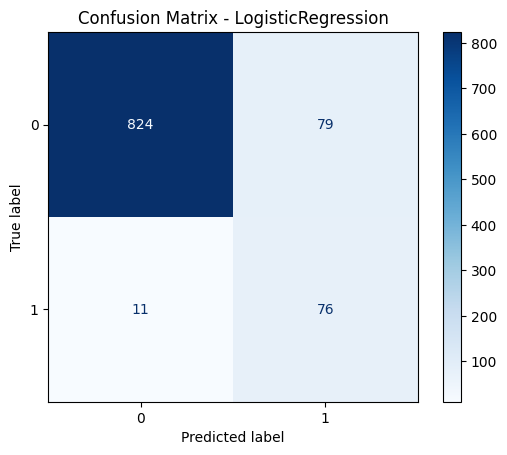

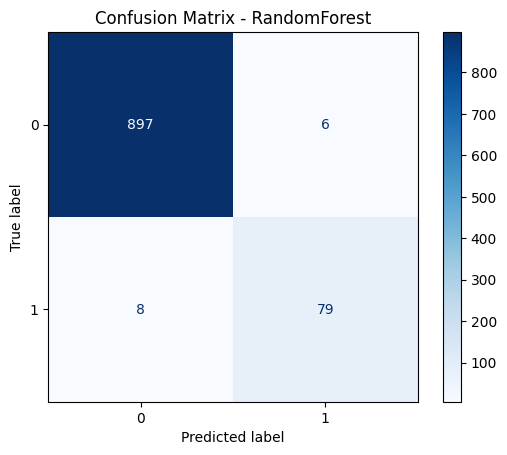

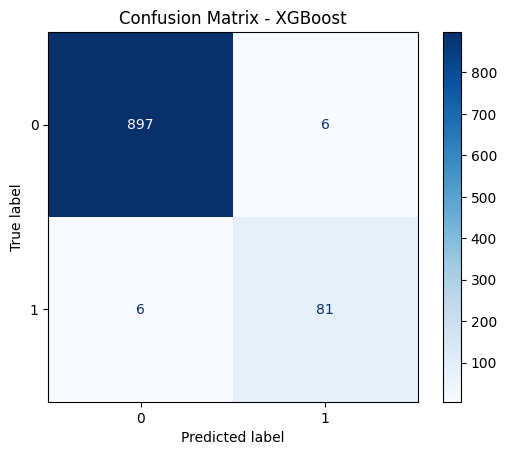

In [17]:
def log_model_with_mlflow(name, model, param_grid, X_train, y_train, X_test, y_test):
    with mlflow.start_run(run_name=name):
        grid = GridSearchCV(model, param_grid, cv=5, scoring='f1')
        grid.fit(X_train, y_train)
        best_model = grid.best_estimator_
        
        # Log best parameters
        mlflow.log_params(grid.best_params_)
        
        # Cross-validation score
        cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='f1')
        mlflow.log_metric("cv_f1_mean", np.mean(cv_scores))
        mlflow.log_metric("cv_f1_std", np.std(cv_scores))

        # Evaluate on test set
        y_pred = best_model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        mlflow.log_metric("test_accuracy", acc)
        mlflow.log_metric("test_f1_score", f1)
        
        print(f"\n{name} Classification Report:")
        print(classification_report(y_test, y_pred))

        # Save confusion matrix as artifact
        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
        disp.plot(cmap="Blues")
        plt.title(f"Confusion Matrix - {name}")
        os.makedirs("plots", exist_ok=True)
        plot_path = f"plots/{name}_conf_matrix.png"
        plt.savefig(plot_path)
        mlflow.log_artifact(plot_path)

        # Log trained model
        mlflow.sklearn.log_model(best_model, f"{name}_model")

# 1. Logistic Regression 
log_params = {'C': [0.01, 0.1, 1, 10], 'solver': ['liblinear']}
log_model_with_mlflow("LogisticRegression", LogisticRegression(max_iter=1000), log_params, X_train_res, y_train_res, X_test, y_test)

# 2. Random Forest 
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}
log_model_with_mlflow("RandomForest", RandomForestClassifier(random_state=42), rf_params, X_train_res, y_train_res, X_test, y_test)

# 3. XGBoost 
xgb_params = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 5]
}
log_model_with_mlflow("XGBoost", XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42), xgb_params, X_train_res, y_train_res, X_test, y_test)

In [5]:
import mlflow
from mlflow.tracking import MlflowClient

client = MlflowClient()
experiment_name = "final_Bank_Personal_Loan_Prediction"
experiment = client.get_experiment_by_name(experiment_name)
experiment_id = experiment.experiment_id

# Find best run (based on test_accuracy)
best_run = None
best_accuracy = -1

for run in client.search_runs(experiment_ids=[experiment_id]):
    acc = run.data.metrics.get("test_accuracy", 0)  # make sure metric name matches your logging
    if acc > best_accuracy:
        best_accuracy = acc
        best_run = run

# Set model name and correct artifact path
model_name = "Best_Loan_Model"
model_artifact_path = "XGBoost_model"  # or "RandomForest_model" / "LogisticRegression_model"

model_uri = f"runs:/{best_run.info.run_id}/{model_artifact_path}"

# Register model
mlflow.register_model(model_uri=model_uri, name=model_name)

print(f"Registered best model from run {best_run.info.run_id} with accuracy {best_accuracy:.4f}")


Successfully registered model 'Best_Loan_Model'.
2025/07/01 19:32:44 WARNING mlflow.tracking._model_registry.fluent: Run with id d77c65532c4544548a5e5fbf558d61ea has no artifacts at artifact path 'XGBoost_model', registering model based on models:/m-016e381611634e0ba8c0c3d349d21817 instead


Registered best model from run d77c65532c4544548a5e5fbf558d61ea with accuracy 0.9879


Created version '1' of model 'Best_Loan_Model'.


In [6]:
import mlflow.sklearn
import pandas as pd
import pickle

# Step 1: Load registered model from MLflow
model = mlflow.sklearn.load_model("models:/Best_Loan_Model/1")  # Adjust version as needed

# Step 2: Load scaler and columns
with open("scaler.pkl", "rb") as f:
    scaler = pickle.load(f)

with open("columns.pkl", "rb") as f:
    columns = pickle.load(f)

# Step 3: Create sample input (ensure it matches training features)
sample_input = pd.DataFrame([[
    45,     # Age
    80000,  # Income
    2,      # Education
    100,    # Mortgage
    1.2,    # CCAvg
    4,      # Family
    1,      # CD Account
    1,      # CreditCard
    0,      # Online
    0,      # Securities Account
    20      # Experience
]], columns=columns)

# Step 4: Scale the input
scaled_input = scaler.transform(sample_input)

# Step 5: Predict
prediction = model.predict(scaled_input)
predicted_proba = model.predict_proba(scaled_input)

# Output
print("Prediction:", prediction[0])  # 0 = not default, 1 = default
print(f"Predicted Probabilities: {predicted_proba[0]}")


Prediction: 0
Predicted Probabilities: [9.999304e-01 6.963278e-05]
